In [1]:
!pip install koreanize-matplotlib
import koreanize_matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\HOME\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


#### 시드(seed) 고정  

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#### 데이터 읽어오기 및 데이터 확인

In [4]:
train = pd.read_csv('C:/Users/HOME/Downloads/범죄분류데이터/train.csv')

train.head()

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


#### 독립변수(x_train), 종속변수(y_train)로 분리하기  


In [5]:
x_train = train.drop(['ID', 'TARGET'], axis = 1)
y_train = train['TARGET']


In [6]:
x_train.head()

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지
0,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
1,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도
2,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도
3,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지
4,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소


#### train , validation data 나누기

In [7]:
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#### 라벨인코딩(Label Encoding) 

In [8]:

ordinal_features = ['요일', '범죄발생지']

for feature in ordinal_features:
    le = LabelEncoder()
    
    # Fit and transform on the training data
    le = le.fit(X_tr[feature])
    X_tr[feature] = le.transform(X_tr[feature])

    # Transform the test data (Note: Only transform, do not fit again to avoid data leakage)
    X_val[feature] = le.transform(X_val[feature])



#### 모델 정의

In [9]:
rf_model = RandomForestClassifier(random_state=42)

#### 모델 학습

In [10]:
rf_model.fit(X_tr, Y_tr)

RandomForestClassifier(random_state=42)

#### 예측

In [11]:
pred = rf_model.predict(X_val)

정확도 : 0.5295
정말도 : 0.5215
Recall: 0.5295
F1 Score: 0.5190
Confusion Matrix:
[[5104 1095 1092]
 [1977 2342  816]
 [2086  877 1493]]


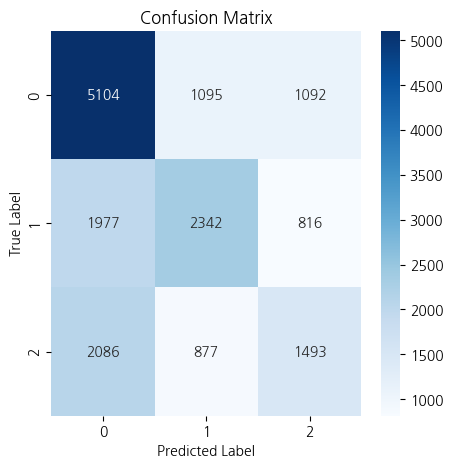

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, pred, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, pred, average='weighted')  # 다중 클래스인 경우 average 설정
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, pred)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### OOB score

In [13]:
# 모델 초기화 및 OOB 점수 계산
rf_model_oob = RandomForestClassifier(random_state=42,oob_score=True)
rf_model_oob.fit(X_tr,Y_tr)

# OOB 점수 출력
print("OOB 점수:", rf_model_oob.oob_score_)

OOB 점수: 0.5145429773117707
